In [66]:
!hostname


rubensolozabal-MSI


In [67]:
TF = 'EGR1'  # Options: 'ETS1', 'EGR1', 'MITF'

In [68]:
import os
os.chdir('/home/solozabal/Documents/projects/TFBind')

In [69]:
import numpy as np
import pandas as pd

In [70]:

if TF == 'ETS1':
    df = pd.read_csv(f'data/ETS1/_ETS1_sMM_vs_positions_mixedLCS340+312-wt.csv', sep=',', header=0)
elif TF == 'EGR1':
    df = pd.read_csv(f'data/EGR1/_EGR1_sMM_vs_positions_MIXED.csv', sep=',', header=0)
elif TF == 'MITF':
    df = pd.read_csv(f'data/MITF/_MITFCbox_sMM_vs_positions_mixedWithLCS342-wt.csv', sep=',', header=0)
else:
    raise ValueError(f'Unknown TF: {TF}')

In [71]:
# Rename Unamed: 0 to Change
df = df.rename(columns={"Unnamed: 0": "Change"})
df

,Change,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11
0,AA,-0.087600,-0.225439,-0.539564,-0.982107,-0.420906,-0.713815,-0.996589,-0.717205,0.002914,0.044895,0.294618
1,AT,0.000000,-0.272840,-0.431797,-1.206102,-0.695698,-0.242513,-1.106306,-0.620852,-0.283320,0.000000,-0.017455
2,AC,-0.128190,-0.220482,-0.698272,-0.889970,-0.301354,-0.381359,-0.842498,-0.352192,0.112709,-0.195447,0.048668
3,AG,-0.055976,-0.386704,-0.438949,-1.092881,-0.725928,-0.701333,-0.948831,-0.870636,0.009681,-0.200952,0.111793
4,AI,-0.103795,-0.483134,-0.486883,-0.951292,-0.687810,-0.548217,-1.074803,-0.811625,-0.315511,0.011378,-0.033031
...,...,...,...,...,...,...,...,...,...,...,...,...
92,DC,-0.616788,-1.101837,-2.017494,-1.820237,-2.123711,-1.383580,-1.620216,-0.918574,-0.566638,0.067854,0.184267
93,DG,-0.517815,-1.409652,-1.397770,-2.486804,-2.298039,-1.729681,-2.006387,-1.727212,-0.307081,0.061437,0.428230
94,DX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95,DU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [72]:
# Unpivot position columns so each numeric value becomes a row, keeping Change and Position
pos_cols = [c for c in df.columns if c.startswith('p') and c[1:].isdigit()]

df_long = (
    df.melt(id_vars='Change', value_vars=pos_cols, var_name='Position', value_name='ln(I)')
      .assign(Position=lambda x: x['Position'].str.extract(r'(\d+)').astype(int))
      .dropna(subset=['ln(I)'])
      .sort_values(['Change', 'Position'])
      .reset_index(drop=True)
)

df_long

,Change,Position,ln(I)
0,AA,1,-0.087600
1,AA,2,-0.225439
2,AA,3,-0.539564
3,AA,4,-0.982107
4,AA,5,-0.420906
...,...,...,...
963,gg,7,-0.890133
964,gg,8,-0.701125
965,gg,9,-0.415841
966,gg,10,-0.155906


In [73]:
# Create a column copying ETS1_PLUS_STRAND and 

from src.constants import *

if TF == 'ETS1':
    PLUS_STRAND = ETS1_PLUS_STRAND
    MINUS_STRAND = ETS1_MINUS_STRAND
    LEN = ETS1_LEN
elif TF == 'EGR1':
    PLUS_STRAND = EGR1_PLUS_STRAND
    MINUS_STRAND = EGR1_MINUS_STRAND
    LEN = EGR1_LEN
elif TF == 'MITF':
    PLUS_STRAND = MITF_PLUS_STRAND
    LEN = MITF_LEN
    MINUS_STRAND = MITF_MINUS_STRAND

df_long['Plus_strand'] = PLUS_STRAND
df_long['Minus_strand'] = MINUS_STRAND


In [74]:
df_long

,Change,Position,ln(I),Plus_strand,Minus_strand
0,AA,1,-0.087600,AGCGTGGGCAC,GTGCCCACGCT
1,AA,2,-0.225439,AGCGTGGGCAC,GTGCCCACGCT
2,AA,3,-0.539564,AGCGTGGGCAC,GTGCCCACGCT
3,AA,4,-0.982107,AGCGTGGGCAC,GTGCCCACGCT
4,AA,5,-0.420906,AGCGTGGGCAC,GTGCCCACGCT
...,...,...,...,...,...
963,gg,7,-0.890133,AGCGTGGGCAC,GTGCCCACGCT
964,gg,8,-0.701125,AGCGTGGGCAC,GTGCCCACGCT
965,gg,9,-0.415841,AGCGTGGGCAC,GTGCCCACGCT
966,gg,10,-0.155906,AGCGTGGGCAC,GTGCCCACGCT


In [75]:
assert LEN == df_long['Position'].max()

In [76]:
from src.utils import *
from src.constants import *

# Assuming df_long has columns Change/Position
df_long[["Plus_strand", "Minus_strand"]] = df_long.apply(
    lambda row: apply_strand_mutation(
        change=row["Change"],
        position=int(row["Position"]),
        plus_strand=PLUS_STRAND,
        minus_strand=MINUS_STRAND,
    ),
    axis=1,
    result_type="expand",
)


In [77]:
df_long

,Change,Position,ln(I),Plus_strand,Minus_strand
0,AA,1,-0.087600,AGCGTGGGCAC,GTGCCCACGCA
1,AA,2,-0.225439,AACGTGGGCAC,GTGCCCACGAT
2,AA,3,-0.539564,AGAGTGGGCAC,GTGCCCACACT
3,AA,4,-0.982107,AGCATGGGCAC,GTGCCCAAGCT
4,AA,5,-0.420906,AGCGAGGGCAC,GTGCCCACGCT
...,...,...,...,...,...
963,gg,7,-0.890133,AGCGTGgGCAC,GTGCgCACGCT
964,gg,8,-0.701125,AGCGTGGgCAC,GTGgCCACGCT
965,gg,9,-0.415841,AGCGTGGGgAC,GTgCCCACGCT
966,gg,10,-0.155906,AGCGTGGGCgC,GgGCCCACGCT


In [78]:
from src.encode import groove_encoding_for_strands

# Apply row-wise to be compatible with different return types (tuple/list/dict/array)
_encoded = df_long.apply(
    lambda r: groove_encoding_for_strands(r["Plus_strand"], r["Minus_strand"]),
    axis=1
)

# Expand results into columns
encoded_df = _encoded.apply(pd.Series)

# Add a helpful prefix if columns are not already named strings
if not all(isinstance(c, str) for c in encoded_df.columns):
    encoded_df.columns = [f"Groove_major", f"Groove_minor"]

# Concatenate with df_long without overwriting existing columns
df_long = pd.concat([df_long, encoded_df], axis=1)

df_long

,Change,Position,ln(I),Plus_strand,Minus_strand,Groove_major,Groove_minor
0,AA,1,-0.087600,AGCGTGGGCAC,GTGCCCACGCA,"[[A, D, D, A], [A, A, D, n], [n, D, A, A], [A,...","[[A, n, n, A], [A, D, A, x], [x, A, D, A], [A,..."
1,AA,2,-0.225439,AACGTGGGCAC,GTGCCCACGAT,"[[A, D, A, M], [A, D, D, A], [n, D, A, A], [A,...","[[A, n, A, x], [A, n, n, A], [x, A, D, A], [A,..."
2,AA,3,-0.539564,AGAGTGGGCAC,GTGCCCACACT,"[[A, D, A, M], [A, A, D, n], [A, D, D, A], [A,...","[[A, n, A, x], [A, D, A, x], [A, n, n, A], [A,..."
3,AA,4,-0.982107,AGCATGGGCAC,GTGCCCAAGCT,"[[A, D, A, M], [A, A, D, n], [n, D, A, A], [A,...","[[A, n, A, x], [A, D, A, x], [x, A, D, A], [A,..."
4,AA,5,-0.420906,AGCGAGGGCAC,GTGCCCACGCT,"[[A, D, A, M], [A, A, D, n], [n, D, A, A], [A,...","[[A, n, A, x], [A, D, A, x], [x, A, D, A], [A,..."
...,...,...,...,...,...,...,...
963,gg,7,-0.890133,AGCGTGgGCAC,GTGCgCACGCT,"[[A, D, A, M], [A, A, D, n], [n, D, A, A], [A,...","[[A, n, A, x], [A, D, A, x], [x, A, D, A], [A,..."
964,gg,8,-0.701125,AGCGTGGgCAC,GTGgCCACGCT,"[[A, D, A, M], [A, A, D, n], [n, D, A, A], [A,...","[[A, n, A, x], [A, D, A, x], [x, A, D, A], [A,..."
965,gg,9,-0.415841,AGCGTGGGgAC,GTgCCCACGCT,"[[A, D, A, M], [A, A, D, n], [n, D, A, A], [A,...","[[A, n, A, x], [A, D, A, x], [x, A, D, A], [A,..."
966,gg,10,-0.155906,AGCGTGGGCgC,GgGCCCACGCT,"[[A, D, A, M], [A, A, D, n], [n, D, A, A], [A,...","[[A, n, A, x], [A, D, A, x], [x, A, D, A], [A,..."


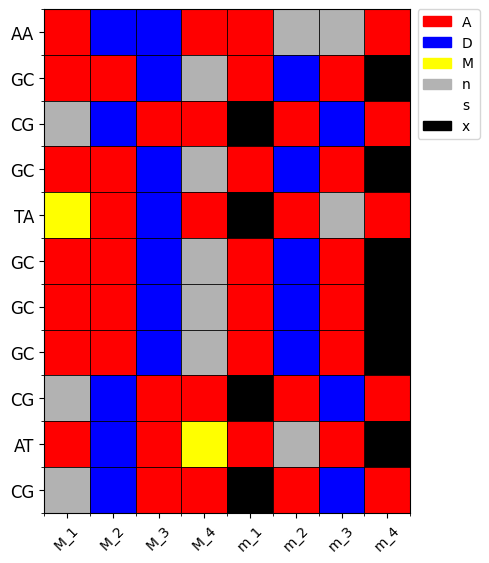

In [79]:
row = df_long.iloc[0]
plot_groove_functional_groups(
    groove_major=row["Groove_major"],
    groove_minor=row["Groove_minor"],
    plus_strand=row.get("Plus_strand"),
    minus_strand=row.get("Minus_strand"),
);


In [80]:
# Save as CSV
out_dir = f'datasets/{TF}'
os.makedirs(out_dir, exist_ok=True)

df_long.to_csv(os.path.join(out_dir, f'dataset_{TF}_encoded.csv'), index=False)